In [12]:
import os
from lxml import etree

# Define the paths to the directories containing the image and annotation files 
dataset_paths = ["CREMMA_fro", "CREMMA_lat", "ECMEN", "Gallicorpora_15"]

# Loop through each dataset directory
for dataset_path in dataset_paths:
    # Define the paths to the annotations and images directories
    annotations_path = os.path.join(dataset_path, "annotations")
    images_path = os.path.join(dataset_path, "images")

## The idea is to automatise the process by filtering out the manuscript images into degrees of abbreviations using the graphematic transcriptions provided via the XML ALTO files. Nevertheless, the transcription norms of each projects are likely different and this factor should be taken into consideration in the following steps.
## As of now the code splits the entire dataset into three categories - fort,moyenne and faible_abbr according to a 0-2 2-5 and 5+ criterion for abbreviation percentage. This can be adjusted according to further observations of the output.

## Todo: create functions out of this bulky code cause this is not cute.

In [13]:
import unicodedata
import pandas as pd

# Define the namespace for ALTO XML
alto_ns = {"alto": "http://www.loc.gov/standards/alto/ns-v4#"}

# Define a dictionary to store the results for each file
results = {}

# Define the threshold percentages for different degrees of abbreviation
thresholds = {"faible_abbr": 1, "moyenne_abbr": 6.5, "fort_abbr": float("inf")}

# Loop through each dataset directory
for dataset_path in dataset_paths:
    # Define the paths to the annotations and images directories
    annotations_path = os.path.join(dataset_path, "annotations")
    images_path = os.path.join(dataset_path, "images")

    # Loop through each XML file in the annotations directory
    for filename in os.listdir(annotations_path):
            if filename.endswith(".xml"):
                file_path = os.path.join(annotations_path, filename)
                image_path = os.path.join(images_path, os.path.splitext(filename)[0] + ".jpg")
                file_name = os.path.splitext(filename)[0]

            print(f"Processing {file_path}...")

            # Parse the XML file using lxml
            tree = etree.parse(file_path)

            # Find all the TextLine elements and concatenate their CONTENT values (= the text)
            text_lines = tree.xpath("//alto:TextLine", namespaces=alto_ns)

            content_list = [line.xpath("string(alto:String/@CONTENT)", namespaces=alto_ns) for line in text_lines]

            # Check if all the content values are empty and skip that file (it happens that we have empty ALTOs)
            if all([content == "" for content in content_list]):
                print("Skipping file - all TextLine elements have empty CONTENT values")
                print("\n")
                continue

            text = "".join([line.xpath("string(alto:String/@CONTENT)", namespaces=alto_ns) for line in text_lines])
            normalized_text = unicodedata.normalize('NFD', text)  # Normalize with NFD form
            combining_chars = [c for c in normalized_text if unicodedata.category(c) == 'Mn']

            # Count the total number of characters and the number of special characters except from allographs
            total_chars = len(normalized_text)
            exclude_chars = ['Λ', 'O', 'ɑ', "⟦","⟧"," ̶", "¶","¬","ﬀ", "ȷ", "•", "ſ", "ı", "·", '́','ŧ', '̈',"δ", "⁋","‸"] #allographetic approach for CREMMA_fro + editing signs such as ⟦ and '̶
            num_special_chars = len([char for char in normalized_text if ord(char) > 127 and char not in exclude_chars])

            # Calculate the percentage of special characters
            if total_chars > 0:
                special_char_percentage = (num_special_chars / total_chars) * 100
            else:
                special_char_percentage = 0

            # Find all the unique special characters in the text
            unique_special_chars = list(set([char for char in normalized_text if ord(char) > 127 and char not in exclude_chars]))
            
                        # Determine the degree of abbreviation
            degree_of_abbr = None
            for tag, threshold in thresholds.items():
                if special_char_percentage <= threshold:
                    degree_of_abbr = tag
                    break

            # Copy the image to the appropriate directory based on the degree of abbreviation
            if degree_of_abbr:
                output_dir = os.path.join(dataset_path, degree_of_abbr)
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                output_image_path = os.path.join(output_dir, file_name + ".jpg")
                os.system(f"cp {image_path} {output_image_path}")
            
            # Store the results for this file in the dictionary
            results[file_name] = {"degree_of_abbr": degree_of_abbr, "unique_special_chars": unique_special_chars, "total_nb_chars": total_chars,"perc_special_chars": special_char_percentage}
            
            # Print the results for this file
            print(f"Total of combining characters: {combining_chars}")
            print(f"Total number of characters: {total_chars}")
            print(f"Number of special characters: {num_special_chars}")
            print(f"Percentage of special characters: {special_char_percentage:.2f}%")
            print(f"Unique special characters: {unique_special_chars}")
            print("\n")
            
            # Create a DataFrame from the results dictionary
df = pd.DataFrame.from_dict(results, orient="index")

# Save the DataFrame to a CSV file
df.to_csv("results.csv")

Processing CREMMA_fro/annotations/KBR9232_f476.xml...
Total of combining characters: ['̃', '̃', '̃', 'ͬ', '̃', '̃', 'ͬ', '̃', '̃', '̃']
Total number of characters: 2868
Number of special characters: 10
Percentage of special characters: 0.35%
Unique special characters: ['̃', 'ͬ']


Processing CREMMA_fro/annotations/BnF412_f228.xml...
Total of combining characters: ['̄', '̄', '̄', 'ͣ', '̄', '̉', '̇']
Total number of characters: 3588
Number of special characters: 56
Percentage of special characters: 1.56%
Unique special characters: ['\uf158', 'ͣ', '̇', 'ᵉ', '̄', 'ꝰ', '̉', 'ꝑ']


Processing CREMMA_fro/annotations/BnF412_f214.xml...
Total of combining characters: ['̄', '̄', '̇', 'ͤ', '̄', '̄', '̃', '̄', '̄', '̇', '̇']
Total number of characters: 3380
Number of special characters: 69
Percentage of special characters: 2.04%
Unique special characters: ['\uf158', 'ꝑ', '̃', '̇', 'ͤ', '̄', '\ue5dc', '\ufeff', '⁊']


Processing CREMMA_fro/annotations/BnF24428_f128.xml...
Total of combining charact

Total of combining characters: ['̃', 'ͥ', '̃', '́', 'ͥ', '᷑', '̃', '̃', 'ͣ', '́', '́', 'ͥ', '̃', '̃', 'ͣ', '̃', '́', '̃', '̃', '̃', '͛', '͛', '̃', 'ͥ', '́', '́', '́', '́', '̃', '́', '́', '᷑', '̃', '̃', '́', '́', 'ͣ', 'ͣ', '̃', '́', '᷑', '̃', 'ͥ', '́', '͛', '́', '́', '́', '̃', '́', '́', 'ͥ', '᷑', '̃', '̃', '̃', '́', '̃', '̃', '́', 'ͦ', '́', '̃', '᷑', 'ͥ']
Total number of characters: 2889
Number of special characters: 59
Percentage of special characters: 2.04%
Unique special characters: ['ͣ', '̃', '͛', 'ꝯ', 'ͦ', '⁹', '᷑', 'ͥ']


Processing CREMMA_fro/annotations/RegLat1616_f097r.xml...
Total of combining characters: ['́', '́', '̃', '̃', '́', '́', '́', '́', '́', '́', '́', '́', '́', '́', '́', '́', '́', 'ͥ', 'ͣ', '͛', '́', '́', '́', '͛', '́', '́', '́', '́', '̃', '̃', 'ͥ', '́', '́', '́', '̃', '̃', 'ͥ', '́', '́', '́', '́', '́']
Total number of characters: 1173
Number of special characters: 23
Percentage of special characters: 1.96%
Unique special characters: ['ͣ', '̃', '͛', 'ꝯ', '\uf1a7', '⁹'

Total of combining characters: ['̃', '̃']
Total number of characters: 1663
Number of special characters: 6
Percentage of special characters: 0.36%
Unique special characters: ['ꝯ', '\uf161', '\xa0', '̃']


Processing CREMMA_fro/annotations/BnF412_f239.xml...
Total of combining characters: ['ᷤ', 'ͣ', 'ͣ', '̄', '̄', 'ᷤ', '̉', '̄', '̄', '̄', '̄', 'ᷤ', '̄']
Total number of characters: 3674
Number of special characters: 44
Percentage of special characters: 1.20%
Unique special characters: ['\uf158', 'ͣ', 'ꝯ', '̄', '̉', 'ᷤ', 'ꝑ', '⁊']


Processing CREMMA_fro/annotations/BnF225_f200v.xml...
Total of combining characters: ['̃', '̃', '̃', 'ͥ', '̃', 'ͤ', '̃', '̃', '̃', '̊', '̣', 'ͣ', '̃', '̃', '̃', '̃', 'ͤ', '̃', '̃', '̃', 'ͭ', 'ͭ']
Total number of characters: 3985
Number of special characters: 65
Percentage of special characters: 1.63%
Unique special characters: ['ͥ', '̣', 'ͣ', '̃', 'ͤ', 'ꝯ', 'ͭ', '̊', 'ꝰ', '⁊']


Processing CREMMA_fro/annotations/BnF25516_f20.xml...
Total of combining character

Total of combining characters: ['́', '̃', '͛', 'ͣ', '̃', 'ͥ', 'ͣ', '̃', '̃', '̃', '͛', '͛', '͛', '̃', '͛', 'ͦ', '̃', '͛', '̃', '́', '̃', '͛', '͛', '́', 'ͥ', '́', '̃', '̃', '́', '͛', '̃', '̃', 'ͥ', '̃', '́', '̃', '͛', '́', '̃', 'ͣ', '̃', '́', '́', '̃', '̃', 'ͥ', '́', '̃', 'ͥ', '̃', '̃', '̃', 'ͣ', '̃', '́', '͛', '́', '̃', '́', '̃', '́', '̃', 'ͣ', '͛', '́', 'ͥ', '́', '͛', '̃', '̃', '̃', '́', '̃', '͛', '́', '̃', '́', '̃', '́', '͛', 'ͣ', '͛', '́', '̃', '͛', '̃', '̃', '́', '͛', '́', '̃', '́']
Total number of characters: 2867
Number of special characters: 87
Percentage of special characters: 3.03%
Unique special characters: ['ͣ', '͛', '̃', '÷', 'ꝯ', 'ͦ', '⁹', 'ͥ', 'ꝓ']


Processing CREMMA_fro/annotations/BnF3516_f333.xml...
Total of combining characters: ['̄', '̄', '̄', '̄', '᷑', '̄', '̄', '̄', '͛', '̄', '̄', '̄', '̄', '̄', '̄', '̄', '̄', '̄', 'ͣ', '̄', 'ͣ', '̄', 'ͣ', '̃', '̄', '̄', '̄', '̃', '̄', '̄', 'ͣ', '̄', 'ͣ', '̄', 'ͣ', '̄', 'ͣ', 'ͣ', '̄', '̄', '͛', '̄', '̄', '̄', '̄', '᷑', '̄', 'ͣ', '

Total of combining characters: ['́', 'ͣ', '́', '́', 'ͣ', '͛', '́', '̃', 'ͥ', '́', 'ͤ', '́', 'ͥ', '̃', '́', 'ͣ', '́', '̃', '́', 'ͥ', '̃', '́', '́', '́', '͛', '́', '̃', '́', '̃', '̃', '̃', '᷑', 'ͣ']
Total number of characters: 1149
Number of special characters: 30
Percentage of special characters: 2.61%
Unique special characters: ['ͣ', '͛', '̃', 'ͤ', 'ꝯ', '\uf1a7', '⁹', '᷑', 'ͥ', '\uf217', 'ꝑ']


Processing CREMMA_fro/annotations/BnF412_f275.xml...
Total of combining characters: ['̇', '̇', '̇', '̇', '̉', 'ͣ', '̇', '̇', '̇', '̇', 'ͣ']
Total number of characters: 3646
Number of special characters: 49
Percentage of special characters: 1.34%
Unique special characters: ['\uf158', 'ͣ', '̇', '̉', 'ꝑ']


Processing CREMMA_fro/annotations/BnF412_f261.xml...
Total of combining characters: ['̄', 'ͥ', 'ᷤ']
Total number of characters: 3860
Number of special characters: 48
Percentage of special characters: 1.24%
Unique special characters: ['\uf158', 'ꝰ', '̄', 'ͥ', 'ᷤ', 'ꝑ']


Processing CREMMA_fro/ann

Total of combining characters: ['̇', '̇', '̉', '̇', '̇', '̇', '̇', '̇', '̉', 'ͣ']
Total number of characters: 3576
Number of special characters: 41
Percentage of special characters: 1.15%
Unique special characters: ['\uf158', 'ͣ', '\ue681', '̇', 'ꝯ', '̉']


Processing CREMMA_fro/annotations/BnF412_f270.xml...
Total of combining characters: ['ͥ', 'ͣ', '̇', '̇', '̇', '̄', '̄', '̇', '̄', '̄', '̇']
Total number of characters: 3441
Number of special characters: 54
Percentage of special characters: 1.57%
Unique special characters: ['\uf158', 'ͣ', '̇', 'ꝯ', '̄', 'ͥ', 'ꝑ']


Processing CREMMA_fro/annotations/BnF412_f264.xml...
Total of combining characters: ['̄', '̇', '̄', '̄']
Total number of characters: 3243
Number of special characters: 42
Percentage of special characters: 1.30%
Unique special characters: ['\uf158', '̇', 'ꝯ', '̄']


Processing CREMMA_fro/annotations/BnF225_f174v.xml...
Total of combining characters: ['̣', '̣', '̃', 'ͣ', '̃', 'ͣ', 'ͣ', 'ᷤ', 'ͣ', '̃', '̃', 'ͣ', 'ͣ', '̃', 'ͣ',

Total of combining characters: ['ͣ', '́', 'ͥ', '̃', '̃', 'ͥ', '͛', 'ͣ', '́', 'ͥ', 'ͥ', '́', '́', '́', '́', '̃', '͛', '́', '́', '́', 'ͥ', '̃', '̃', '͛', '̃', '͛', '́', '́', '̃', 'ͤ', '̃', 'ͣ', '́', '́', 'ͥ', '́', 'ͥ', 'ͥ', '̃', '́', '́', '̃']
Total number of characters: 1113
Number of special characters: 37
Percentage of special characters: 3.32%
Unique special characters: ['ͣ', '̃', '÷', '͛', 'ͤ', 'ꝯ', '\uf1a7', 'ͥ', 'ꝑ']


Processing CREMMA_fro/annotations/RegLat1616_f117v.xml...
Total of combining characters: ['̃', '̃', '̃', '́', '́', '̃', '́', '͛', '́', '̃', '̃', 'ͥ', '̃', '͛', '́', '̃', '̃', '͛', '͛', '́', '̃', '̃', '͛', 'ͥ', '̃', '́', '̃', '̃', 'ͥ', 'ͥ', '́', '͛', '̃', '̃', '̃', '̃', '͛', '́', '͛', '̃', '̃', '͛']
Total number of characters: 1127
Number of special characters: 47
Percentage of special characters: 4.17%
Unique special characters: ['͛', '̃', 'ꝯ', '\uf1a7', '⁹', 'ͥ', 'ꝑ']


Processing CREMMA_fro/annotations/BnF412_f256.xml...
Total of combining characters: ['ᷤ', '̉', '

Total of combining characters: ['̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', 'ͥ', '̃', '̃', '̃', '̃', '̃']
Total number of characters: 902
Number of special characters: 36
Percentage of special characters: 3.99%
Unique special characters: ['ꝑ', '⁊', '̃', 'ͥ']


Processing CREMMA_fro/annotations/UPenn660_9.xml...
Total of combining characters: ['̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '͛', '̃', '̃', '̃', '̃', '̃', '̃']
Total number of characters: 1289
Number of special characters: 40
Percentage of special characters: 3.10%
Unique special characters: ['\uf128', '͛', '̃', 'ꝰ', 'ꝑ']


Processing CREMMA_fro/annotations/UPenn660_8.xml...
Total of combining characters: ['̃', '̃', '̃', '͛', '̃', 'ͬ', '̃', '͛', 'ͬ', '̃', '̃', 'ͬ', '̃', '̃', 'ͥ', '͛', '̃', '̃', '̃', 'ͭ', '̃', '̃', '̃', '̃', '̃', '̃', '͛', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃']
Tota

Total of combining characters: ['̄', '̄', '̄', '̄', 'ᷤ', '̄']
Total number of characters: 3741
Number of special characters: 53
Percentage of special characters: 1.42%
Unique special characters: ['\uf158', 'ꝯ', '̄', 'ᷤ', 'ꝑ']


Processing CREMMA_fro/annotations/BnF225_f343.xml...
Total of combining characters: ['̃', '̃', '̣', '̃', 'ͤ', '̃', '̃', '̃', 'ͣ', '̃', 'ͣ', 'ͤ', 'ͣ', '̃', '̃', 'ͥ', '̃', 'ͣ', '̃', '̃', '̃', '̃', 'ͣ']
Total number of characters: 3794
Number of special characters: 39
Percentage of special characters: 1.03%
Unique special characters: ['ͥ', '̣', 'ͣ', '̃', 'ͤ', 'ꝯ', 'ꝰ', '⁊']


Processing CREMMA_fro/annotations/BnF412_f245.xml...
Total of combining characters: ['̇', '̄', '̄', '̉', '̇', '̇']
Total number of characters: 3719
Number of special characters: 52
Percentage of special characters: 1.40%
Unique special characters: ['\uf158', '̇', 'ꝯ', '̄', '̉', 'ꝑ']


Processing CREMMA_fro/annotations/UPenn909_f63v.xml...
Total of combining characters: ['̃', '̃', '̃', '̃', '̃'

Total of combining characters: ['̄', '̄', '̄', 'ͥ', '̄', 'ͥ', '̅', '̄', '̅', '᷑', 'ͣ', '̄', '̅', 'ͣ']
Total number of characters: 1717
Number of special characters: 28
Percentage of special characters: 1.63%
Unique special characters: ['\uf158', 'ͣ', '\ue681', '̅', '̄', 'ꝯ', '᷑', 'ͥ', 'ꝑ']


Processing CREMMA_fro/annotations/KBR9232_f537.xml...
Total of combining characters: ['̃', '̃', '̃', '̃', '̃', 'ͬ', '̃', 'ͬ', '̃', '̃', '̃', '̃', '̃', '̃', '̃', 'ͬ', '̃', '̃', '̉']
Total number of characters: 3018
Number of special characters: 19
Percentage of special characters: 0.63%
Unique special characters: ['̉', '̃', 'ͬ']


Processing CREMMA_fro/annotations/UPenn909_f72v.xml...
Total of combining characters: ['̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̾', '̃', '̃', '̃', 'ͬ', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', 'ͬ', '̃', 'ͬ', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̾', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃'

Total of combining characters: ['̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃']
Total number of characters: 3271
Number of special characters: 19
Percentage of special characters: 0.58%
Unique special characters: ['̃']


Processing CREMMA_fro/annotations/BnF24428_f137.xml...
Total of combining characters: ['̄', '̄', 'ͥ', '̅', 'ͦ', '̅', '̄', '̄', '̄', '̄', '̄', '̅', '̄', '̄', '͛', '̅', '͛', '̄', 'ͥ', '̅', '̅', '̄', '͛', '͛', '̄', '̄', '͛', '̄']
Total number of characters: 1829
Number of special characters: 54
Percentage of special characters: 2.95%
Unique special characters: ['\uf158', 'ͥ', '\ue681', '͛', '̅', '̄', 'ꝯ', 'ͦ', 'ꝰ', 'ꝑ']


Processing CREMMA_fro/annotations/UPenn909_f52v.xml...
Total of combining characters: ['̃', '̾', 'ͬ', '̾', '̃', '̃', '̃', '̃', 'ͬ', 'ͥ', '̾', '̃', '̃', 'ͤ', '̃', 'ᷤ', 'ᷤ', 'ͬ', '̾', 'ͬ', 'ͬ', '̃', '̃', '̃', 'ͬ', '̃', 'ͬ', '̃', '̃', '̃', '̃', '̾', '̃', 'ͥ', '̃', '̃', 'ͬ', '̃', '̃', '̃', 'ͬ', '̃', '̃', '̃', '̃

Total of combining characters: ['͛', '́', '́', '́', '́', 'ͥ', 'ͦ', '́', '́', 'ͣ', '́', '́', '̃', '́', '́', 'ͥ', '́', '́', '̃', '́', '́', '́', '́', '́', '́', '͛', '́', '̃', '́', '́', '͛', '́', '́', '́', '́', '́', '̃', '́', 'ͥ', '́', '́', 'ͣ', '́', '́', '́', '́', '́', '́', '́', '́', '́', 'ͥ', '́', '́', '̃', '́', '́', '́', '́', '́', '̃', '́', '́', '́', '́', '́', '́', 'ͣ', '́', '́', '́', '́', 'ͥ', '͛', '́', '͛', '́']
Total number of characters: 1110
Number of special characters: 44
Percentage of special characters: 3.96%
Unique special characters: ['ͣ', '͛', '̃', '\uf1a7', 'ͦ', '⁹', 'ͥ', 'ꝛ', 'ꝑ']


Processing CREMMA_fro/annotations/UPenn909_f69v.xml...
Total of combining characters: ['̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', 'ͭ', '̃', '̃', '̃', '̃', '̽', '̃', '̃', '̃', '̃', '̃', '̃', 'ͬ', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̽', '̃', '̃', '̃', '̃', '̃', 'ͬ', '̃', '̃', '̽', '̃', '̃', '̃', '̃', '̃', 'ͬ', '̃', 'ͬ', '̃', '̃']
Total

Total of combining characters: ['̄', 'ᷤ', '̇', '̄', '̄', '̄', '̉', '̅']
Total number of characters: 3492
Number of special characters: 58
Percentage of special characters: 1.66%
Unique special characters: ['\uf158', '̇', 'ꝯ', '̄', '̅', '̉', '\ufeff', 'ᷤ', 'ꝑ', '\xa0']


Processing CREMMA_fro/annotations/BnF412_f231.xml...
Total of combining characters: ['ᷤ', '̄', '̄', '̄', '̄']
Total number of characters: 3546
Number of special characters: 39
Percentage of special characters: 1.10%
Unique special characters: ['\uf158', 'ꝯ', '̄', 'ᷤ', 'ꝑ']


Processing CREMMA_fro/annotations/BnF844_f13.xml...
Total of combining characters: ['ͥ', '̃', '̃', '̃', '̃', '̃', 'ͦ', '̃', '̃']
Total number of characters: 1852
Number of special characters: 13
Percentage of special characters: 0.70%
Unique special characters: ['ꝯ', 'ͦ', '̃', 'ͥ']


Processing CREMMA_fro/annotations/UPenn909_f64r.xml...
Total of combining characters: ['̃', '̃', 'ͬ', '̃', 'ͬ', '̃', '̃', '̃', '̃', 'ͬ', '̃', '̃', '̃', '̃', '̃', '̃', '

Total of combining characters: ['ͣ', '̃', 'ͣ', '̃', '̃', 'ͣ', '̃', '̃', 'ͣ', '̾', '̃', '̾', 'ͨ', 'ͦ', 'ᷤ', 'ͫ', 'ᷝ', 'ͤ', '̃', 'ͤ', '̃', 'ͥ', 'ͣ', 'ͣ', '̃', '̃', 'ͫ', 'ͣ', 'ͭ', '̃', 'ͤ', 'ͣ', 'ͣ', '̃', 'ͦ', 'ͣ', '᷑', 'ͦ', 'ͦ', '̃', '̃', 'ͭ', 'ͣ', '̃', '̃', '̃', 'ͣ', '̃', '̃', '̃', '̃', 'ͦ', '̃', '̃', '̃', 'ͦ', 'ͨ', 'ͣ', 'ͣ', '̃', 'ͣ', '̃', 'ͭ', 'ͤ', '̃', '̃', 'ͬ', '̃', 'ͣ', '̃', '̃', '̃', 'ͣ', 'ͭ', 'ͣ', 'ᷤ', '̃', '̃', '̾', 'ͣ', '̾', '̃', '̃', '̃', 'ͣ', 'ͣ', 'ͣ', '̃', '̃', '̃', 'ͣ', 'ͨ', 'ͣ', '̾', 'ͣ', 'ͭ', 'ͣ', '̃', 'ͭ', 'ͥ', '̃', '̃', '̃', 'ͣ', 'ͬ', '̾', '̃', '̾', 'ͣ', 'ͤ', '̃', '̃', 'ͤ', '̃', 'ͦ', '̃', '̃', '̃', 'ͣ', 'ͥ', 'ͤ', 'ͣ', 'ͣ', 'ͣ', 'ͥ', 'ͦ', '̾', '̃', 'ͣ', 'ͣ', 'ͣ', 'ͣ', 'ͦ', '̃', 'ͨ', 'ͣ', 'ͣ', 'ͣ', 'ͣ', '̃', '̃', '̃', 'ͫ', '̃', 'ͣ', 'ͣ', 'ͭ', 'ͦ', 'ͣ', 'ͫ', 'ͤ', '̃', 'ͤ', 'ᷝ', 'ͤ', 'ͨ', '̃', 'ͦ', 'ͭ', 'ͣ', '̃', 'ͦ', 'ͬ', 'ͣ', 'ͣ', '̃', 'ͦ', 'ͬ', 'ͦ', 'ͫ', '̃', 'ͣ', 'ͣ', '̃', 'ͦ', 'ͦ', '̃', 'ͬ', 'ͤ', 'ͭ', '᷑', '̃', 'ͫ', 'ͣ', 'ͦ', '᷑', 'ͭ', 'ͥ', '̃', '̾', '̃', 'ͦ', '̃', 'ᷝ'

Total of combining characters: ['̃', '̃', 'ͣ', '̃', '̃', '̃', '̃', '̾', '̾', '̃', '̃', '̾', '̾', '̃', 'ͥ', 'ͥ', '̃', '̃', '̃', 'ͥ', '᷑', 'ͣ', '̾', '̃', '̃', '̃', '̃', 'ͣ', '̃', '̃', 'ͣ', '̃', '̃', '᷑', 'ͥ', '̾', '̃', '̃', '̾', '̃', '̃', '̃', '̃', '̃', '̾', '̃', '̃', 'ͦ', 'ͥ', '̾', '̃', '̃', 'ͨ', '̃', '̃', 'ͣ', '̃', '̾', '̃', '̃', '̃', '̾', '̶', 'ͥ', '̾', '̃', '̃', '̾', '̃', '̃', '̃', 'ͥ', '̃', '̃', '̃', '̃', '᷑', 'ͥ', '̃', '̃']
Total number of characters: 1297
Number of special characters: 98
Percentage of special characters: 7.56%
Unique special characters: ['ͣ', '̶', '̃', 'ͨ', 'ꝰ', '\uf1ac', 'ͦ', '᷑', 'ͥ', 'ꝓ', 'ꝑ', '⁊', '̾']


Processing CREMMA_lat/annotations/SBB-PK-Hdschr25_f62r.xml...
Total of combining characters: ['̃', '̃', '̾', '̃']
Total number of characters: 310
Number of special characters: 8
Percentage of special characters: 2.58%
Unique special characters: ['\uf1ac', 'ꝑ', '̃', '̾']


Processing CREMMA_lat/annotations/BIS-193_f447.xml...
Total of combining characters: ['ͣ'

Total of combining characters: ['̃', '̃', '̃', '̃']
Total number of characters: 232
Number of special characters: 6
Percentage of special characters: 2.59%
Unique special characters: ['Ꝑ', '⁊', '̃']


Processing CREMMA_lat/annotations/CLM13027_f39r.xml...
Total of combining characters: ['ͣ', '̾', '̾', '̾', '̾', '̾', '̃', '̃', 'ͣ', '̾', '̃', '̃', '᷑', '̃', '̾', 'ͥ', '̃', '̾', '̾', '̃', '̾', 'ͦ', '̃', '̾', '̃', 'ͦ', '̃', '̾', '̾', '᷑', '̃', 'ͣ', '̾', '̃', '̾', '̾', '̃', 'ͣ', '̾', 'ͦ', '̃', '̃', '̃', '̃', '̾', '̾', '̾', '̾', '̾', '᷑', '̃', '᷑', 'ͦ', '̃', '̃', 'ͣ', '̃', '̾', '̃', '̃', 'ͣ', '̃', '̃', '̃', '̃', '̃', '᷑', '̃', '̃', '̾', '̃', 'ͥ', 'ᷤ', '̃', '̃', '̃', '̃', '̃', '̇', '̃', '̾', '̃', '̃', 'ͦ', '̃', '᷑', '̃', '̃', '̃', '̃', '̾', '̾', '̃', '̃', '̃', '̾', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '᷑', 'ͨ', '̃', '̃', 'ͦ', '̃', '̃', '̾', '̾', 'ͥ', '̃', '̃', 'ͥ', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̾', '̾', '̃', '̾', '̃', 'ᷤ', '̃', '̃', '̃', '̾', '̾', '̃', '̃', '̃', '̾', '̃', 'ͦ', '̃', '̃

Total of combining characters: ['̃', '̾', '̾', '̾', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', 'ͥ', 'ͤ', '̃', '̃', '̃', '̾', '̃', '̃', '̃', '̾', 'ͥ', '̃', '̾', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̾', '̃', '̃', '̃', '̃', '̃', '̃', '̾', '᷑', '̃', '̃', 'ͦ', '̃', '̾', '̾', '̾', '̾', '̾', '̃', 'ͥ', '̃', '̾', '̃', '̃', '̃', '̃', '̃', '̾', '̾', '̃', '̾', '̃', 'ͣ', '̾', '̃', 'ͣ', 'ͥ', '̃', '̃', '̾', 'ͥ', '̾', '᷑', '̃', 'ͦ', '̃', '̃', '̃', '̃', '̾', 'ͦ', '̃', '̃', '̃', 'ᷤ', '̃', '̾', '̃', '̃', 'ͥ', '̃', 'ͥ', '̃', 'ͥ', 'ͥ', '̃', '̃', '̃', '̃', '̾', '̃', '̃', '̾', '̃', '̃', '̃', '̃', '̃', '̃', '̾', 'ͣ', '̃', '̾']
Total number of characters: 1470
Number of special characters: 174
Percentage of special characters: 11.84%
Unique special characters: ['ꝑ', 'ͣ', 'ħ', 'ł', '̃', 'ͤ', 'ꝰ', '\uf1ac', 'ͦ', 'ẜ', '᷑', 'ᷤ', 'ͥ', 'ꝵ', 'ꝗ', '⁊', '̾']


Processing CREMMA_lat/annotations/Egerton821_f55r.xml...
Total of combining characters: ['̃', '̃', '̾', '̃', '̃', '̃', '̾', '̃', 'ͥ', '̃', '

Total of combining characters: ['̃', 'ͣ', 'ͣ', '̃', '̃', 'ͥ', '̃', 'ͫ', '̃', '̃', 'ͥ', 'ᷤ', '̃', '̃', '̃', '̃', '᷑', '̃', 'ͥ', '̃', '̃', '̃', '̃', '̃', '̃', '̃', 'ᷤ', '̾', '̾', '̃', '̾', '̃', '̃', '̃', '̾', '̾', '̃', '̃', '̃', '᷑', 'ͦ', '̃', '̃', '̃', '̃', 'ͦ', '̃', '᷑', '̃', '̾', '̾', '̃', '̃', 'ͥ', '̃', 'ͥ', '̃', '̃', '̃', '̃', '̃', 'ͥ', 'ᷤ', '̃', '̃', 'ͥ', '̃', 'ͥ', 'ͦ', '̃', '̃', '̃', '̃', '̃', '̃', 'ͥ', 'ͥ', '̃', 'ͥ', 'ᷤ', '̃', '̃', 'ͭ', '̃', 'ͥ', '̃', '̾', '̃', 'ͥ', '̃', '̃', '̃', '̃', 'ͦ', '̃', '̃', '̾', '̾', '̃', 'ͫ', '̶', '̃', '̃', '̾', '̃', '̃', '̃', '̃', '̃', '̃', 'ͦ', '̃', '̾', 'ͤ', '̃', '̃', 'ͥ', '̃', 'ͥ', 'ᷤ', '̃', 'ͥ', 'ᷤ', '̃', '̃', 'ᷤ', '̃', '̃', '᷑', 'ͣ', '̃', '̾', 'ͥ', '̃', 'ͤ', 'ͥ', '̃', '̃', '̃', '̾', '̾', '̶', '̃', '̃', 'ͦ', '̶', '̃', 'ͥ', 'ᷤ', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '᷑', 'ͥ', '̃', '̾', '̃', '̃', '̃', '̃', '̃', 'ͤ', 'ͭ', '̃', '̃', 'ͥ', '̃', 'ͥ', 'ͤ', '̃', '̃', 'ͥ', 'ᷤ', '̃', '̃', '̃', 'ͥ', 'ᷤ', 'ͥ', '̃', '̃', 'ͥ', '̃', 'ͦ', '̃', '᷑', '̃', '̃'

Total of combining characters: ['ͣ', '̃', '̃', '̃', '̃', '̃', '̃', 'ᷤ', 'ͣ', '̃', '̾', '̃', '̃', '̃', '̃', 'ͥ', '̃', '̃', '̃', '̃', '᷑', 'ᷤ', '̃', 'ͥ', '̃', 'ͦ', '̃', '̾', '̃', '̃', '̃', '̾', '̃', '̃', '̃', '̃', 'ͥ', '̃', 'ͦ', '̃', 'ͥ', '̃', '̾', '̃', '̃', 'ͣ', 'ᷤ', '̃', '̃', 'ͥ', '̃', '̃', '̃', 'ͥ', '̃', '̾', '̃', '̃', 'ͥ', '̃', '̾', '̃', '̾', '̾', 'ᷤ', '̃', '̃', 'ͣ', '̃', '̾', 'ͥ', '̃', '̃', '᷑', '̃', 'ͣ', '᷑', 'ᷤ', 'ͣ', '᷑', 'ͥ', '᷑', '᷑', 'ͥ', '̇', 'ᷤ', 'ͥ', '̃', 'ͦ', '̃', 'ͥ', '̃', '̃', '̃', 'ͥ', '̃', '̃', '̾', 'ͥ', 'ͥ', '̃', '̃', '̾', '̃', '̃', '̃', '᷑', '̃', '̾', '̃', 'ͣ', '̃', '̾', '᷑', '̃', '̾', 'ᷤ', '̾', 'ͥ', '̃', 'ͦ', 'ᷤ', '̃', '̃', '̃', 'ͥ', '̃', '̃', '̃', 'ͦ', '̃', '̾', '̾', '̃', '̃', '̃', '̾', 'ᷤ', '̃', 'ͥ', '᷑', 'ͥ', '̃', '̃', '̾', '̃', '̃', 'ͥ', '̾', '̃', '̃', '̃', '᷑', 'ͥ', '̃', '̃', '̃', '̾', '̾', 'ͦ', '̃', '̃', 'ᷤ', 'ᷤ', '̃', '̾', '̃', '̃', 'ͣ', '̃', 'ͥ', '̃', '̃', '̃', 'ᷤ', 'ᷤ', '̃', '̃', '̃', '̾', 'ᷤ', '̃', '̾', '̃', '̇', 'ͥ', '̃', '̃', 'ᷤ', '̃', '̃', '᷑', '̃', '̃'

Total of combining characters: ['̃', '̃', '̃', '̃', '̃', 'ͥ', 'ͥ', '̃', 'ͨ', 'ͨ', 'ͣ', '̾', 'ͨ', '̃', 'ͣ', 'ͥ', 'ͣ', '̾', '̃', '̃', 'ͥ', '̃', '᷑', '̃', 'ͨ', 'ͦ', 'ͦ', '̃', '̃', '̃', '̃', '̾', '̃', 'ͥ', '̃', '̃', 'ͣ', '̃', '̃', '̃', 'ͦ', '̾', '̃', '̃', '̃', '̃', '̾', '̃', '᷑', 'ͥ', 'ͥ', '̃', '̃', '̶', '̾', '̾', '̃', '̃', '̾', '̾', '̾', '̃', '̃', '̃', '̃']
Total number of characters: 1255
Number of special characters: 81
Percentage of special characters: 6.45%
Unique special characters: ['ͣ', '̶', '̃', 'ͨ', 'ꝰ', '\uf1ac', 'ͦ', '᷑', 'ͥ', 'ꝑ', '⁊', '̾']


Processing CREMMA_lat/annotations/H318_f11rv-12r.xml...
Total of combining characters: ['ͥ', '̾', '̾', 'ͦ', '̃', '̾', '̃', 'ͥ', 'ᷤ', 'ͥ', 'ͣ', '̃', '̃', '̃', '̃', '̃', 'ͥ', 'ͣ', '̾', 'ͣ', '̃', '̃', '̃', '̃', 'ͥ', '̃', 'ͦ', 'ᷤ', '̃', 'ͥ', 'ᷤ', '̾', 'ͣ', 'ᷤ', '̾', '̃', 'ᷤ', '̾', 'ͥ', '̾', '̃', '̃', '̃', 'ᷤ', '̃', '̃', 'ͥ', 'ᷤ', '̾', 'ͣ', 'ͥ', 'ͣ', '̾', '̃', '̃', '̾', '̃', '̃', 'ͣ', 'ͣ', '̾', '̃', '̃', 'ᷝ', '̃', '̃', '̃', '̃', 'ͦ', 'ͦ', 'ᷤ',

Total of combining characters: ['̃', '̾', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̾', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̾', '̾', '̃', '̃']
Total number of characters: 1602
Number of special characters: 66
Percentage of special characters: 4.12%
Unique special characters: ['ꝑ', '̃', '\uf1ac', '\ue5dc', 'ꝰ', 'ꝓ', 'ꝵ', '⁊', '̾']


Processing CREMMA_lat/annotations/H318_f10r.xml...
Total of combining characters: ['̃', '̾', '̃', '̃', '̾', '̾', '̃', 'ͣ', '̾', '̾', '̃', '̾', '̾', '̾', '̃', '̃', 'ͤ', '̃', '̃', '᷑', '̃', '̾', '̾', '̃', '̃', '̃', 'ͣ', '̾', '᷑', '̃', '̾', '̾', '̃', 'ᷤ', '̾', '̃', '̃', 'ͤ', '̃', '̾', 'ͣ', '̾', '̾', '̃', 'ͦ', 'ͣ', '̃', '̾', 'ᷤ', '̾', '̃', '̃', '̾', '̾', '̃', '̃', 'ͣ', 'ᷤ', 'ᷤ', 'ͣ', 'ͦ', 'ͣ', '᷑', '̃', 'ᷤ', '̃', '̾', '̾', 'ͣ', 'ͣ', '̃', '̾', '̾', '̾', 'ͣ', 'ͣ', 'ᷤ', '̃', '̃', '̃', '̾', 'ͣ', '̾', '̃', '̾', '̃', '̃', '̃', '̾', 'ᷤ', '̃', 'ͦ', '᷑', '̃', '̾', '̃', '̃', 'ᷤ', '̃', '̃',

Total of combining characters: ['᷑', '̃', '̾', '̾', '̃', '̾', 'ͣ', 'ͣ', '̃', '̃', 'ͣ', '̃', '̃', 'ͣ', '̃', 'ͥ', '᷑', '̃', '̾', '̾', 'ͥ', '̃', 'ͣ', 'ͣ', '̃', '̃', '̃', '̃', 'ͣ', '̃', 'ͥ', 'ͣ', '̾', '̃', '̃', 'ͥ', '̃', '̃', '̃', '̶', '̶', '̶', '̃', 'ͥ', '̾', '̃', '̃', '̃', '̾', '̃', 'ͣ', '̃', '̃', '̃', '̾', '̾', '̃', 'ͦ', 'ᷤ', '̃', '̾', '̃', 'ͣ', '̃', '᷑', 'ͥ', 'ᷤ', '̃', '̃', '̃', '̾', '̾', 'ͣ', '̃', 'ͣ', '̾', '̾', '̃', '̃', '̃', '̃', 'ᷤ', '̾', '̃', '̃', '̃', '̃', 'ͣ', '̃', 'ᷤ', 'ͣ', 'ͣ', '̃', '̃', '̾', '̃', '̃', '̃', '̾', '̾', '̃', '̃', '̾', 'ͣ', '̾', '̾', 'ͫ', 'ͥ', 'ᷤ', 'ͥ', '̾', '̾', '̾', '̾', 'ͣ', 'ͣ', 'ᷤ', '̃', '̾', '̾', '̾', '̾', 'ͦ', 'ͬ', '̃', 'ͣ', '̾']
Total number of characters: 1846
Number of special characters: 199
Percentage of special characters: 10.78%
Unique special characters: ['̶', '̃', 'ꝙ', 'ͥ', 'ͬ', '⁊', '\uf2da', 'ꝯ', 'ᷤ', 'ł', 'ꝰ', 'ꝵ', 'ꝑ', 'ͣ', '℥', 'ħ', '\uf1ac', 'ͦ', '᷑', 'ꝓ', 'ͫ', '̾']


Processing CREMMA_lat/annotations/SBB-PK-Hdschr25_f21r.xml...
Total of comb

Total of combining characters: ['̧', '́', '̃', '̃', '̃', '̃', '̃', '̃', 'ͥ', '́', '̧', '̧', '̧', '̧', 'ͣ', '̃', '̃', '́', '͛', '̃', '̃', '᷒', '̃', '̃', '̃', '́', '̃', '́', '́', '́', '́', '́', '̃', '̃', '́', '̃', '̧', '͛', '᷑', '᷒', '̃', '̃', '̃', '̃']
Total number of characters: 2974
Number of special characters: 37
Percentage of special characters: 1.24%
Unique special characters: ['ͣ', '̧', '̃', '͛', 'ꝯ', '\uf1a7', '᷒', '᷑', 'ͥ', 'ꝓ']


Processing ECMEN/annotations/btv1b8452642g_f11_.xml...
Skipping file - all TextLine elements have empty CONTENT values


Processing ECMEN/annotations/btv1b8451616p_f29_.xml...
Total of combining characters: ['́', '́', '᷑', '̃', '́', '́', '̃', '̃', '̃', '́', '̃', '́', 'ͣ', '̧', '̃', '́', 'ͥ', '́', '̧', '̃', '̃', '́', '́', '́', '̃', 'ͣ', '́', '́', '᷒', '̃', '́', '̃', '́', '́', '̃']
Total number of characters: 2292
Number of special characters: 24
Percentage of special characters: 1.05%
Unique special characters: ['ͣ', '̧', '̃', 'ẜ', '᷑', 'ͥ', '᷒', '\ue6

Total of combining characters: ['́', '́', '́', '́', '̃', '́', '́', '́', '́', '́', '́', '́', '́', '́', '́', '̈', '̃', '́', '̧', '́', '́', '́', '́', '́', '́', '́', '́', '́']
Total number of characters: 2245
Number of special characters: 3
Percentage of special characters: 0.13%
Unique special characters: ['̧', '̃']


Processing ECMEN/annotations/btv1b10511088k_f59_.xml...
Skipping file - all TextLine elements have empty CONTENT values


Processing ECMEN/annotations/btv1b10502007v_f55_.xml...
Skipping file - all TextLine elements have empty CONTENT values


Processing ECMEN/annotations/btv1b72000256_f47_.xml...
Total of combining characters: ['̃', '̃', 'ͥ', 'ͣ', '̃', 'ͤ', '̃', '̃', 'ͣ', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', 'ͥ', 'ͣ', '̧', '̃', '̃', 'ͤ', 'ͣ', '̃', '̃', '̃', '̃', 'ͤ', '̃', '̃', '̃', 'ͣ', '̃', 'ͣ', '́', '́', '̃', '̃', '̃', '̃', 'ͣ', '̃', '́', '́', '̃', '́', '̃', '̃', '̈', '́']
Total number of characters: 1614
Number of special characters: 64
Percentage of special

Total of combining characters: ['̃', '᷒', '̃', '̃', '̃', '̃', '̃', '̃']
Total number of characters: 1460
Number of special characters: 9
Percentage of special characters: 0.62%
Unique special characters: ['᷒', '⁊', '̃']


Processing ECMEN/annotations/btv1b8447296x_f17_.xml...
Total of combining characters: ['᷒', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃']
Total number of characters: 1166
Number of special characters: 12
Percentage of special characters: 1.03%
Unique special characters: ['ꝑ', '᷒', '⁊', '̃']


Processing ECMEN/annotations/btv1b105154602_f45_.xml...
Total of combining characters: ['̃', '́', '́', 'ͥ', '́', '́', 'ͥ', '̃', '́', 'ͣ', '̃', '̃', 'ͤ', '͛', 'ͤ', '̃', '̈', '́', '̈', '́', '́', '͛', '́', '̃', '̧', 'ͤ', '̃', '́', '̃', '̃', '̈']
Total number of characters: 1729
Number of special characters: 44
Percentage of special characters: 2.54%
Unique special characters: ['ͣ', '̧', '̃', '͛', 'ͤ', 'ꝯ', '\uf1a7', 'ͥ', 'ꝑ']


Processing ECMEN/annotations/btv1b6000083z_f21_.xml...
T

Total of combining characters: ['́', '̃', '̃', '̃', '̃', '̃', '̧', '̃', '̃', '́', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃']
Total number of characters: 2026
Number of special characters: 28
Percentage of special characters: 1.38%
Unique special characters: ['\uf1a6', '̧', '⁊', '̃']


Processing ECMEN/annotations/btv1b9058190x_f16_.xml...
Skipping file - all TextLine elements have empty CONTENT values


Processing ECMEN/annotations/btv1b9059315z_f53_.xml...
Skipping file - all TextLine elements have empty CONTENT values


Processing ECMEN/annotations/btv1b8539714c_f9_.xml...
Total of combining characters: ['̃', '̃', '᷒', '᷒', '̃', '᷒', '᷒', '̃', '᷒', '̃', '̃', '̃', 'ͥ', '̃', '̃', '̃']
Total number of characters: 2086
Number of special characters: 17
Percentage of special characters: 0.81%
Unique special characters: ['ꝓ', '᷒', '̃', 'ͥ']


Processing ECMEN/annotations/btv1b90095492_f22_.xml...
Skipping file - all TextLine elements have empty CONTENT values


Pr

Total of combining characters: ['́', '́', '́', '́', '́', '̧', '́', '̧', '́', '́']
Total number of characters: 1338
Number of special characters: 7
Percentage of special characters: 0.52%
Unique special characters: ['̧', '\uf1a7']


Processing ECMEN/annotations/btv1b105065252_f67_.xml...
Total of combining characters: ['̃', '̃', '̃']
Total number of characters: 581
Number of special characters: 9
Percentage of special characters: 1.55%
Unique special characters: ['ꝯ', '\uf1a7', '⁊', '̃']


Processing ECMEN/annotations/btv1b8449039t_f15_.xml...
Total of combining characters: ['̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '᷒']
Total number of characters: 1548
Number of special characters: 12
Percentage of special characters: 0.78%
Unique special characters: ['᷒', '̃']


Processing ECMEN/annotations/btv1b9059385m_f325_.xml...
Total of combining characters: ['̃', '͛', '͛', '́', '̈', '̃', '̃', 'ͥ', '̃', 'ͬ', 'ͥ', 'ͣ', '̈', 'ͣ', 'ͣ', '̃', '̈', '̃', '̃', '̃', '̃', '̧', '̃', '᷒', '̃', 

Total of combining characters: ['́', '̃', '̃', '̃', '̃', '́', '́', '̃', '̃', '̃', '̃', '́', '̃', '́', '̧', '͛', '̧', '̃', '̃', '́', '́', '́', '́', '́', '́']
Total number of characters: 3149
Number of special characters: 20
Percentage of special characters: 0.64%
Unique special characters: ['̧', '͛', '̃', '\uf1a7', 'ꝑ']


Processing ECMEN/annotations/btv1b9059081x_f12_.xml...
Skipping file - all TextLine elements have empty CONTENT values


Processing ECMEN/annotations/btv1b8530344b_f37_.xml...
Total of combining characters: ['̃', '̃', '̃', '̃', '̈', '́', '̃', '̈', '̃', '̃', '́', '̃', '̃', '᷑', '͛', '̃', '̃', '͛', '͛', '́', '́', '̃', '͛', '́', '́', '̃', '́', 'ͣ', '̃', '̃', '́', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '́', '̃', '̃', '᷒', '̃', '̃', '᷑', '̃', '̃', 'ͤ', '̃', '́', '̃', '́', '́', '̃', '̃']
Total number of characters: 3665
Number of special characters: 64
Percentage of special characters: 1.75%
Unique special characters: ['ꝑ', 'ͣ', '͛', '̃', 'ͤ', 

Total of combining characters: ['́', 'ͣ', '̃', 'ͣ', '̃', '́', '̃', '̃', '̈', 'ͣ', '̈', '́', '́', '̃', 'ͣ', 'ͣ', '̃', 'ͣ', '̃', '̃', '̈', '́', '̈', '́', 'ͥ', '̃', '̈', '̈', '̃', '́', '́', '́', '́', '̃', '̃', '́']
Total number of characters: 3034
Number of special characters: 53
Percentage of special characters: 1.75%
Unique special characters: ['ͣ', '̃', 'ꝯ', '\uf1a7', 'ͥ', 'ꝑ']


Processing ECMEN/annotations/btv1b10509758f_f13_.xml...
Total of combining characters: ['́', '́', '᷑', '̃', '́', '́', '̃', '̃', '᷑', 'ͦ', '̈']
Total number of characters: 697
Number of special characters: 13
Percentage of special characters: 1.87%
Unique special characters: ['ͦ', '\uf1a7', '᷑', '̃']


Processing ECMEN/annotations/btv1b9009528w_f27_.xml...
Total of combining characters: ['́', '̃', '́', 'ͬ', 'ͥ', '̧', '̃', '̃', '́', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '́', '́', '̃', '̃', '̃', 'ͥ', '̧', '́', '̃', '̃', '̃', '́', '̃', 'ͥ', '́', '̈', '̃', '̃', '́', '̃', '̃', '̃', '́', '́', '́', '́', '̃

Total of combining characters: ['͛', '᷒', '᷒', '᷒', '᷒', '̃', '̃']
Total number of characters: 1364
Number of special characters: 8
Percentage of special characters: 0.59%
Unique special characters: ['᷒', 'ꝑ', '͛', '̃']


Processing ECMEN/annotations/btv1b90636444_f4_.xml...
Total of combining characters: ['̃', '᷒', '̃', '̃', '̃', '̃', '̃', '᷒', '᷒', '᷒', '̃', 'ͥ', '̃', '᷒', '̃', '᷒', '̃', '̃', 'ͥ', '᷒', '̃', '̃', '̃', '᷒', '̃', '᷒', '̃']
Total number of characters: 1297
Number of special characters: 30
Percentage of special characters: 2.31%
Unique special characters: ['᷒', 'ꝑ', '̃', 'ͥ']


Processing ECMEN/annotations/btv1b8571073f_f9_.xml...
Total of combining characters: ['̃', '̃']
Total number of characters: 358
Number of special characters: 2
Percentage of special characters: 0.56%
Unique special characters: ['̃']


Processing ECMEN/annotations/btv1b10527646p_f108_.xml...
Total of combining characters: ['̃', '͛', '͛', '̃', 'ͥ', '̈', '́', '̈', '̃', 'ͥ', '̃', '᷒', 'ͥ', '̧', '̃', '᷒

Total of combining characters: ['̃', '̃', '̃']
Total number of characters: 484
Number of special characters: 4
Percentage of special characters: 0.83%
Unique special characters: ['ꝑ', '̃']


Processing ECMEN/annotations/btv1b90589090_f12_.xml...
Skipping file - all TextLine elements have empty CONTENT values


Processing ECMEN/annotations/btv1b10525355t_f1018_.xml...
Total of combining characters: ['̧', '̈', '́', '́']
Total number of characters: 1050
Number of special characters: 1
Percentage of special characters: 0.10%
Unique special characters: ['̧']


Processing ECMEN/annotations/btv1b9058841v_f16_.xml...
Total of combining characters: ['̃', '̃', '̃', 'ͥ', 'ͥ', 'ͥ', '̧', '̃', 'ͥ', '̧', '̃', '᷒', '̃', '᷒', '̃', '̃', 'ͥ', '̃', '̃', '᷒', 'ͥ', '̃', 'ͥ', '᷒', '̃', '̃', '᷒', '᷒', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', 'ͥ', '́', '̃', '̃', '́', '̃', '̃', '̃', '̃', 'ͥ', '̃', 'ͣ', '̃', '́', 'ͥ', '̃', '́', '̃', '̃', '᷒', '̃', '̃', '̃', '̃', '̃', '̧', '̃', '̃', '̃', '̃', '᷒', '

Total of combining characters: ['̃', '̃']
Total number of characters: 1075
Number of special characters: 2
Percentage of special characters: 0.19%
Unique special characters: ['̃']


Processing Gallicorpora_15/annotations/btv1b55008562q_f21.xml...
Total of combining characters: ['̃', '̃']
Total number of characters: 1228
Number of special characters: 3
Percentage of special characters: 0.24%
Unique special characters: ['⁊', '̃']


Processing Gallicorpora_15/annotations/btv1b8448964p_f14.xml...
Total of combining characters: ['̃', '̃', '̾', 'ͨ', '̾', 'ͬ', '̃', '̃', '̃']
Total number of characters: 1017
Number of special characters: 11
Percentage of special characters: 1.08%
Unique special characters: ['̃', 'ͨ', 'ˣ', 'ͬ', '̾']


Processing Gallicorpora_15/annotations/btv1b90076543_f55.xml...
Total of combining characters: ['̃', '̃', '̃', '̾', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', 'ͤ', '̃', '̃', '̃', '̾', '̃', '̃', '̃', '̾', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃'

Total of combining characters: ['̃', 'ͥ', '̃', '̃', '̃', '̃', '̃', '̃', 'ͣ', '̃', '̃', '̃', '̾', '̃', 'ͣ', '̃', '̾', '̃', '᷑', '̃', '̃', 'ͥ', '̃', '̃', '̾', '̾', 'ͥ', '̃', '̃', '᷑', '̃', '᷑', '̃', '̃', '᷑', '᷑', '̃', '̃', '̃', '̃', '̃', '̾', '̃', '̃', '̃', 'ͣ', '̃', '̃', '̾', '̃']
Total number of characters: 4598
Number of special characters: 77
Percentage of special characters: 1.67%
Unique special characters: ['ͣ', '̃', 'ꝯ', 'ꝰ', '᷑', 'ͥ', 'ꝑ', '⁊', '̾']


Processing Gallicorpora_15/annotations/btv1b90076543_f25.xml...
Total of combining characters: ['̃', '̾', '̃', '̃', 'ᷤ', 'ͤ', '̃', '̃', '̃', '᷑', 'ͣ', '̃', '̃', 'ͣ', '̃', '̃', '̃', 'ͣ', '̃', '̃', '̾', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '᷑', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̶', '̃', '̃', '̃', '̃', '̃', '̾', '̃']
Total number of characters: 5519
Number of special characters: 73
Percentage of special characters: 1.32%
Unique special characters: ['ꝑ', 'ͣ', 'ħ', '̶', '̃', 'ͤ', 'ẜ', '᷑', 'ꝰ', 'ᷤ', '⁊', '̾']




Total of combining characters: ['̃', '̃', '̃', '̃', '̾', '̃', 'ͫ', 'ͤ']
Total number of characters: 2793
Number of special characters: 36
Percentage of special characters: 1.29%
Unique special characters: ['ꝑ', '̃', 'ͤ', 'ͫ', 'ẜ', '⁊', '̾']


Processing Gallicorpora_15/annotations/btv1b9009670t_f94.xml...
Total of combining characters: ['̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃']
Total number of characters: 2684
Number of special characters: 34
Percentage of special characters: 1.27%
Unique special characters: ['ꝑ', '⁊', '̃', 'ꝰ']


Processing Gallicorpora_15/annotations/btv1b55008562q_f29.xml...
Total of combining characters: ['̃', '̃', '̃']
Total number of characters: 1149
Number of special characters: 3
Percentage of special characters: 0.26%
Unique special characters: ['̃']


Processing Gallicorpora_15/annotations/btv1b10549431k_f201.xml...
Total of combining characters: ['̃', 'ͣ', '̃', '̃', 'ͥ', '̃', '̾', '̃', '̃', '̶', '̶', 'ͣ', '᷑', 

Total of combining characters: ['̃', '̃', '̃', '̃', '̃', '̃', 'ͤ', '̃', '̃', '̃', '̃', '̃']
Total number of characters: 2836
Number of special characters: 17
Percentage of special characters: 0.60%
Unique special characters: ['ͤ', '⁊', '̃']


Processing Gallicorpora_15/annotations/btv1b90069505_f24.xml...
Total of combining characters: ['ͣ', '̃', '̃', '̃', '̃', '̃']
Total number of characters: 2741
Number of special characters: 12
Percentage of special characters: 0.44%
Unique special characters: ['ꝑ', 'ͣ', '̃', 'ẜ', 'ꝰ', '⁊']


Processing Gallicorpora_15/annotations/btv1b100737746_f16.xml...
Total of combining characters: ['̃', '̃', '̃', '̃', '̃', 'ͯ', '̶', '̃', '̃', '̃', '̶', '̶', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̃', '̶', '̃', '̃', '̃', 'ͣ', '̾', '̃', '̃', '̃', '̶', '̃', '̃', '̃']
Total number of characters: 3182
Number of special characters: 37
Percentage of special characters: 1.16%
Unique special characters: ['ͣ', '̶', '̃', 'ꝰ', 'ͯ', '̾']


Processing Gallicorpora_15/

In [3]:
df.describe()

,total_nb_chars,perc_special_chars
count,693.000000,693.000000
mean,2394.145743,3.074350
std,1517.226266,3.813935
min,35.000000,0.000000
25%,1304.000000,0.937766
50%,1999.000000,1.823881
75%,3243.000000,3.719723
max,11298.000000,22.805483


<Axes: >

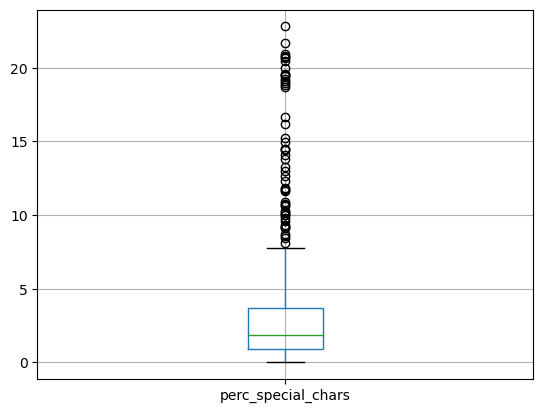

In [4]:
import matplotlib.pyplot as plt
df.boxplot(column="perc_special_chars")